# Profesional I
## Analítica
### Departamento de Analítica y Gestión de Información
#### Prueba Específica - Junio 2021

Uno de los principales inconvenientes en la masificación de los productos de crédito móviles es el conocimiento del ingreso real del cliente. Para este tipo de canales es de alta importancia la información que se puede capturar en el momento de la solicitud, en
donde se puede pedir al cliente diligenciar una serie de variables demográficas (edad, género, estrato, empleador, etc.) y su ingreso mensual. 

Se ha identificado que existe una población de clientes que declara niveles de ingresos mucho mayores a los que realmente devengan, para los cuales es necesario construir una política que permita ajustar su endeudamiento.

Su objetivo es utilizar la base de datos proporcionada para determinar cuáles son los factores que influyen en que un cliente declare un ingreso superior al realmente devengado, y plantear recomendaciones accionables basadas en sus hallazgos.

Adicional al diagnóstico arriba mencionado, usted deberá construir un modelo de clasificación que permita identificar a los clientes que con mayor probabilidad estarían declarando un ingreso superior al real (utilice 20% como umbral para definir que el ingreso fue mayor).


Para solucionar el problema se plantea el siguiente esquema:
    
**1.** Realice labores de limpieza, exploración, y visualización de la información, que le permitan llegar a conclusiones preliminares y responder preguntas de tipo descriptivo (regiones con mayor desviación, estratos con mayor desviación, edades con mayor desviación, etc.)

**2.** Construya un modelo analítico que permita determinar si un cliente declara ingresos superiores a los reales. Explique de qué manera escogió el modelo y qué métricas utilizó para validar su desempeño.

**3.** Explique a manera de conclusión como se puede utilizar el resultado del modelo planteado, y cómo se podrían crear polìticas que mitiguen el riesgo de estos clientes.

*Recuerde que las conclusiones y/o recomendaciones deben ser accionables, es decir, deben generar un posible plan de acción que permita mejorar el resultado encontrado.*

## Solución

El primer paso es importar las librerias de Python útiles para el análisis de los datos y el desarrollo de los modelos analiticos.

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
%matplotlib inline 
import matplotlib.pyplot as plt

Se utiliza el método de Pandas `read_excel()` para cargar los datos desde el archivo suministrado.

In [2]:
cc_analytics = pd.read_excel("AnexoProfesionalIAnalítica.xlsx")
cc_analytics.head()

,id,tipo_p,CANAL,EDAD,TIPO_CLIENTE_CUENTAS,INGRESO_DECLARADO,INGRESO_REAL,ACIERTA,NIVEL_RIESGO,TIPO_VENTA,SUCURSAL,REGIONAL
0,1,Independiente,WEB,41-50,Antiguo,400000.0,1250.000,675,MEDIO,Asistido,BOYACA,CENTRO SUR
1,2,Independiente,APP,31-35,Antiguo,150000.0,781.242,717,MEDIO,Asistido,BOGOTA,BOGOTA Y CUNDINAMARCA
2,3,Independiente,APP,36-40,Nuevo Act Dav,140000.0,785.979,753,MEDIO,Asistido,BOGOTA,BOGOTA Y CUNDINAMARCA
3,4,Independiente,WEB,41-50,Antiguo,150000.0,1135.000,849,BAJO,Asistido,BOGOTA,BOGOTA Y CUNDINAMARCA
4,5,Independiente,APP,36-40,Antiguo,90000.0,781.242,653,MEDIO,Asistido,VALLE,VALLE


Es útil conocer los tipos de variables de los datos para decidir sobre el método de visualización a usar.

In [3]:
cc_analytics_info = cc_analytics.info()
print(cc_analytics_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5333 non-null   int64  
 1   tipo_p                5333 non-null   object 
 2   CANAL                 5333 non-null   object 
 3   EDAD                  5333 non-null   object 
 4   TIPO_CLIENTE_CUENTAS  5333 non-null   object 
 5   INGRESO_DECLARADO     5333 non-null   float64
 6   INGRESO_REAL          5333 non-null   float64
 7   ACIERTA               5333 non-null   int64  
 8   NIVEL_RIESGO          5333 non-null   object 
 9   TIPO_VENTA            5333 non-null   object 
 10  SUCURSAL              5333 non-null   object 
 11  REGIONAL              5333 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 500.1+ KB
None


A continuación se identifican los valores faltantes y usando un loop, se puede calcular el número de valores faltantes en cada columna. 
"True" representa un valor perdido, "False" significa que el valor está presente en el conjunto de datos. En el *bucle*, el método `.value_counts ()` cuenta el número de valores "True".

In [4]:
missing_data = cc_analytics.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

id
False    5333
Name: id, dtype: int64

tipo_p
False    5333
Name: tipo_p, dtype: int64

CANAL
False    5333
Name: CANAL, dtype: int64

EDAD
False    5333
Name: EDAD, dtype: int64

TIPO_CLIENTE_CUENTAS
False    5333
Name: TIPO_CLIENTE_CUENTAS, dtype: int64

INGRESO_DECLARADO
False    5333
Name: INGRESO_DECLARADO, dtype: int64

INGRESO_REAL
False    5333
Name: INGRESO_REAL, dtype: int64

ACIERTA
False    5333
Name: ACIERTA, dtype: int64

NIVEL_RIESGO
False    5333
Name: NIVEL_RIESGO, dtype: int64

TIPO_VENTA
False    5333
Name: TIPO_VENTA, dtype: int64

SUCURSAL
False    5333
Name: SUCURSAL, dtype: int64

REGIONAL
False    5333
Name: REGIONAL, dtype: int64



Con base en esta información se sabe que cada columna tiene 5333 filas de datos. En ninguna columna se presentan datos faltantes.
 
Utilizando el método `.describe()` se obtiene información estadística de los datos, tanto de las variables categoricas como de las númericas.

In [5]:
cc_analytics_description_categ = cc_analytics.describe(include=['object'])
print(cc_analytics_description_categ)

          tipo_p CANAL    EDAD TIPO_CLIENTE_CUENTAS NIVEL_RIESGO TIPO_VENTA  \
count       5333  5333    5333                 5333         5333       5333   
unique         3     2       7                    3            3          2   
top     Empleado   APP   41-50              Antiguo        MEDIO   Asistido   
freq        3715  4253    1461                 2732         3118       3198   

       SUCURSAL               REGIONAL  
count      5333                   5333  
unique       21                      7  
top      BOGOTA  BOGOTA Y CUNDINAMARCA  
freq       2289                   2289  


In [6]:
cc_analytics_description_values = cc_analytics.describe()
print(cc_analytics_description_values)

                id  INGRESO_DECLARADO  INGRESO_REAL      ACIERTA
count  5333.000000        5333.000000   5333.000000  5333.000000
mean   2667.000000        8667.895975   4302.222439   753.593475
std    1539.648824       13502.841959   4928.627632    84.908766
min       1.000000           0.004000    737.717000   457.000000
25%    1334.000000        3343.042000    902.780000   687.000000
50%    2667.000000        5400.000000   2210.000000   746.000000
75%    4000.000000        9900.000000   5690.042000   812.000000
max    5333.000000      400000.000000  54481.000000   999.000000


In [7]:
cc_analytics.isnull().sum()

id                      0
tipo_p                  0
CANAL                   0
EDAD                    0
TIPO_CLIENTE_CUENTAS    0
INGRESO_DECLARADO       0
INGRESO_REAL            0
ACIERTA                 0
NIVEL_RIESGO            0
TIPO_VENTA              0
SUCURSAL                0
REGIONAL                0
dtype: int64

Nos interesa clasificar a los clientes según la diferencia porcentual entre el valor real y el valor reportado de ingresos. Siguiendo las recomendaciones se usara la siguiente clasificación:
 * 1 (True): si el ingreso reportado es >20%  del ingreso real
 * 0 (False): para los otros casos (<=20%)

In [8]:
dif_Perc = 100*np.absolute(((cc_analytics["INGRESO_REAL"]-cc_analytics["INGRESO_DECLARADO"]))/(cc_analytics["INGRESO_REAL"]))

cc_analytics["dif_Perc"] = dif_Perc

cc_analytics["REPORTA_MAYOR_INGRESO"] = 0 

for i in cc_analytics.index:
    if(cc_analytics["INGRESO_REAL"][i]<cc_analytics["INGRESO_DECLARADO"][i]):
        if(cc_analytics["dif_Perc"][i] > 20.0):
            cc_analytics.loc[i,"REPORTA_MAYOR_INGRESO"] = 1
    else:
        cc_analytics.loc[i,"REPORTA_MAYOR_INGRESO"] = 0

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cc_analytics.columns.to_numpy():
    if cc_analytics[col].dtypes == 'object':
        cc_analytics[col]=le.fit_transform(cc_analytics[col])

In [10]:
#cc_analytics.head(-5)

In [11]:
from sklearn.model_selection import train_test_split
cc_analytics = cc_analytics.drop(["id","CANAL","TIPO_VENTA","REGIONAL","dif_Perc"], axis=1)
cc_analytics = cc_analytics.to_numpy()

X,y = cc_analytics[:,0:8], cc_analytics[:,8]

X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.33,
                                random_state=42)

In [12]:
# Import MinMaxScaler
# ... YOUR CODE FOR TASK 8 ...
from sklearn.preprocessing import MinMaxScaler
# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

print ('Train set:', rescaledX_train.shape,  y_train.shape)
print ('Test set:', rescaledX_test.shape,  y_test.shape)

Train set: (3573, 8) (3573,)
Test set: (1760, 8) (1760,)


In [13]:
# Import LogisticRegression
# ... YOUR CODE FOR TASK 9 ...
from sklearn.linear_model import LogisticRegression
# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit logreg to the train set
# ... YOUR CODE FOR TASK 9 ...
logreg.fit(rescaledX_train,y_train)

LogisticRegression()

In [17]:
# ... YOUR CODE FOR TASK 10 ...
from sklearn.metrics import confusion_matrix
# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(rescaledX_test)
y_pred


array([1., 1., 1., ..., 1., 1., 0.])

In [19]:
y_pred_prob = logreg.predict_proba(rescaledX_test)
y_pred_prob

array([[0.1067577 , 0.8932423 ],
       [0.32239025, 0.67760975],
       [0.1618705 , 0.8381295 ],
       ...,
       [0.41647163, 0.58352837],
       [0.23398245, 0.76601755],
       [0.60317866, 0.39682134]])

### Evaluación

### jaccard index

Lets try jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.


In [20]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, y_pred,pos_label=0)

0.5085714285714286

### confusion matrix

Another way of looking at accuracy of classifier is to look at **confusion matrix**.

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[1060   66]
 [ 278  356]]


Confusion matrix, without normalization
[[1060   66]
 [ 278  356]]


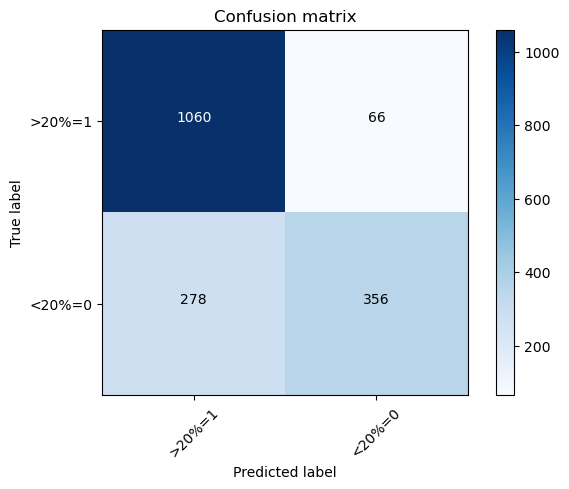

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['>20%=1','<20%=0'],normalize= False,  title='Confusion matrix')

In [28]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.56      0.67       634
         1.0       0.79      0.94      0.86      1126

    accuracy                           0.80      1760
   macro avg       0.82      0.75      0.77      1760
weighted avg       0.81      0.80      0.79      1760



### log loss

Now, lets try **log loss** for evaluation. In logistic regression, the output can be the probability of customer churn is yes (or equals to 1). This probability is a value between 0 and 1.
Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1. 

In [30]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_prob)

0.41879518565629126

In [23]:
#from sklearn.metrics import confusion_matrix
# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logreg.score(rescaledX_test,y_test))

# Print the confusion matrix of the logreg model
# ... YOUR CODE FOR TASK 10 ...
confusion_matrix(y_test,y_pred)

Accuracy of logistic regression classifier:  0.8045454545454546


array([[ 356,  278],
       [  66, 1060]])

In [32]:
# Import GridSearchCV
# ... YOUR CODE FOR TASK 11 ...
from sklearn.model_selection import GridSearchCV
# Define the grid of values for tol and max_iter
tol = [0.01,0.001,0.0001]
max_iter = [100,150,200]

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = dict(tol=tol, max_iter=max_iter)

In [16]:
# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

# Use scaler to rescale X and assign it to rescaledX
rescaledX = scaler.fit_transform(X)

# Fit grid_model to the data
grid_model_result = grid_model.fit(rescaledX, y)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.777616 using {'max_iter': 100, 'tol': 0.01}
